<a href="https://colab.research.google.com/github/MInner/lrmf/blob/main/jax_gmm_vanishing_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
import jax.numpy as np
from jax.scipy.stats.norm import pdf as normal_pdf
from jax.scipy.stats.norm import logpdf as normal_logpdf
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


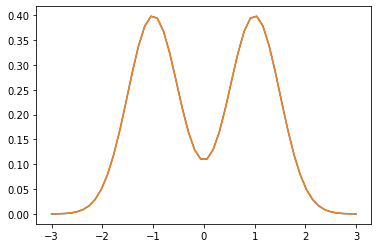

In [ ]:
def normal_equal_mixture_pdf(x, mu1, sigma1, mu2, sigma2):
  p1 = normal_pdf(x, mu1, sigma1)
  p2 = normal_pdf(x, mu2, sigma2)
  return 0.5 * (p1 + p2)

def normal_equal_mixture_logpdf(x, mu1, sigma1, mu2, sigma2):
  lp1 = normal_logpdf(x, mu1, sigma1)
  lp2 = normal_logpdf(x, mu2, sigma2)
  log2 = np.log(2)
  return logsumexp(np.vstack([lp1 - log2, lp2 - log2]), axis=0)

def sample_equal_mixture(n, mu1, sigma1, mu2, sigma2):
  s1 = jax.random.normal(jax.random.PRNGKey(0), (n//2,)) * sigma1 + mu1
  s2 = jax.random.normal(jax.random.PRNGKey(0), (n - n//2,)) * sigma2 + mu2
  return np.concatenate([s1, s2])

def sample_mixture_entropy(n, mu1, sigma1, mu2, sigma2):
  xx = sample_equal_mixture(n, mu1, sigma1, mu2, sigma2)
  logp = np.log(normal_equal_mixture_pdf(xx, mu1, sigma1, mu2, sigma2))
  return np.mean(logp)

xx = np.linspace(-3, 3)
pp = normal_equal_mixture_pdf(xx, -1.0, 0.5, 1.0, 0.5)
plt.plot(xx, pp)
pp2 = np.exp(normal_equal_mixture_logpdf(xx, -1.0, 0.5, 1.0, 0.5))
plt.plot(xx, pp2)

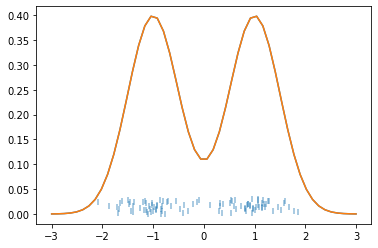

In [ ]:
samp = sample_equal_mixture(100, -1.0, 0.5, 1.0, 0.5)
plt.scatter(samp, 0.03*jax.random.uniform(jax.random.PRNGKey(0), (len(samp),)), marker='|', alpha=0.5)

xx = np.linspace(-3, 3)
pp = normal_equal_mixture_pdf(xx, -1.0, 0.5, 1.0, 0.5)
plt.plot(xx, pp)
pp2 = np.exp(normal_equal_mixture_logpdf(xx, -1.0, 0.5, 1.0, 0.5))
plt.plot(xx, pp2)

-0.0029283594 0.00012862682


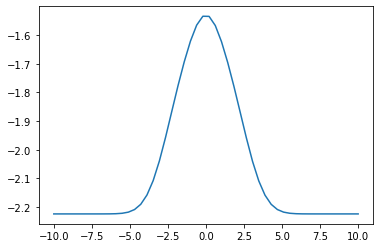

In [ ]:
n = 100000
a1_mu, a2_mu, a_sigma = -1.0, 1.0, 0.5
delta = abs(a2_mu - a1_mu) / 2
b1_mu = (a1_mu + a2_mu) / 2
b_sigma = np.sqrt(a_sigma**2 + delta**2)
fixed_samp = sample_equal_mixture(n, a1_mu, a_sigma, a2_mu, a_sigma)

print(np.mean(fixed_samp) - b1_mu, np.std(fixed_samp) - b_sigma)

def cross_entropy_vs_b2_mu(b2_mu):
  logp = normal_equal_mixture_logpdf(fixed_samp, b1_mu, b_sigma, b2_mu, b_sigma)
  return np.mean(logp)

b2_mu_xx = np.linspace(-10, 10)
plt.plot(b2_mu_xx, [cross_entropy_vs_b2_mu(x) for x in b2_mu_xx])

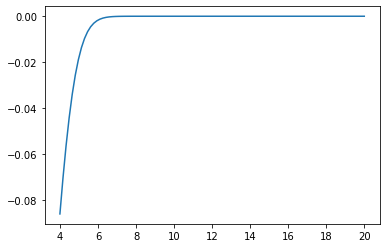

In [ ]:
d_cross_emtropy_d_b2mu = jax.grad(cross_entropy_vs_b2_mu, 0)
d_cross_emtropy_d_b2mu_vmap_jit = jax.jit(jax.vmap(d_cross_emtropy_d_b2mu, 0))
b2_mu_xx = np.linspace(4, 20, 100)
d_ce_d_b2_mu = d_cross_emtropy_d_b2mu_vmap_jit(b2_mu_xx)
plt.plot(b2_mu_xx, d_ce_d_b2_mu)

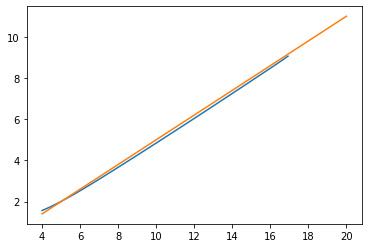

In [ ]:
plt.plot(b2_mu_xx, np.sqrt(-1 * np.log(-1 * d_ce_d_b2_mu)))
plt.plot(b2_mu_xx, 0.6*b2_mu_xx - 1)

In [ ]:
import scipy.stats
import numpy as onp

reg = scipy.stats.linregress(onp.array(b2_mu_xx)[20:-20], onp.array(np.sqrt(-1 * np.log(-1 * d_ce_d_b2_mu)))[20:-20])

In [ ]:
a = reg.slope
b = reg.intercept
print(reg.rvalue)
print(a, b)

0.9999617621108599
0.6018194143276179 -1.168793041415567


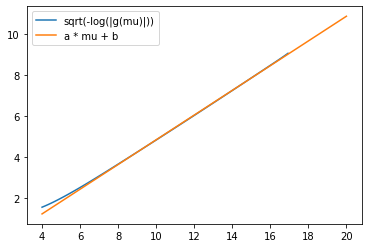

In [ ]:
plt.plot(b2_mu_xx, np.sqrt(-1 * np.log(-1 * d_ce_d_b2_mu)), label='sqrt(-log(|g(mu)|))')
plt.plot(b2_mu_xx, a*b2_mu_xx + b, label='a * mu + b')
plt.legend(loc='best')
plt.show()

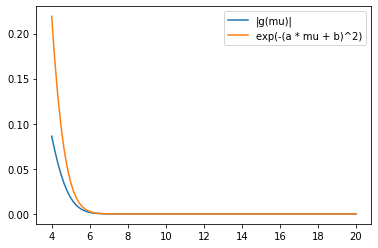

In [ ]:
d_ce_est = -1 * np.exp( -1 * (b2_mu_xx * 0.6 -1.168)**2 )
plt.plot(b2_mu_xx, np.abs(d_ce_d_b2_mu), label='|g(mu)|')
plt.plot(b2_mu_xx, np.abs(d_ce_est), label='exp(-(a * mu + b)^2)')
plt.legend(loc='best')
plt.show()

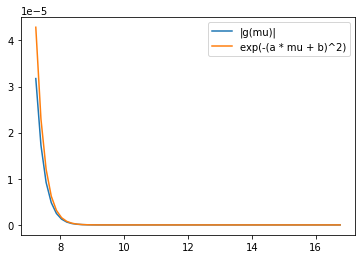

In [ ]:
d_ce_est = -1 * np.exp( -1 * (b2_mu_xx * 0.6 -1.168)**2 )
plt.plot(b2_mu_xx[20:-20], np.abs(d_ce_d_b2_mu)[20:-20], label='|g(mu)|')
plt.plot(b2_mu_xx[20:-20], np.abs(d_ce_est)[20:-20], label='exp(-(a * mu + b)^2)')
plt.legend(loc='best')
plt.show()

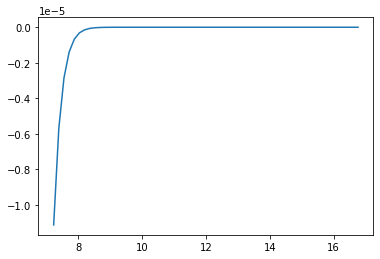

In [ ]:
plt.plot(b2_mu_xx[20:-20], (d_ce_est - d_ce_d_b2_mu)[20:-20])

In [ ]:
print(b2_mu_xx)
print((abs(d_ce_est - d_ce_d_b2_mu) / abs(d_ce_d_b2_mu))[20:-20].mean())

[ 4.         4.1616163  4.323232   4.4848485  4.646465   4.8080807
  4.969697   5.1313133  5.292929   5.4545455  5.6161613  5.7777777
  5.939394   6.1010103  6.262626   6.4242425  6.5858583  6.7474747
  6.909091   7.0707073  7.232323   7.3939395  7.555556   7.7171717
  7.878788   8.040403   8.202021   8.363636   8.525252   8.686869
  8.848485   9.010101   9.171717   9.333334   9.494949   9.656566
  9.818182   9.979797  10.141415  10.30303   10.464646  10.626263
 10.787879  10.949495  11.111112  11.272727  11.434343  11.59596
 11.757576  11.919191  12.080808  12.242424  12.40404   12.565657
 12.727273  12.888889  13.050505  13.212121  13.373737  13.535354
 13.69697   13.858586  14.020202  14.181818  14.343434  14.505051
 14.666667  14.828282  14.989899  15.151515  15.313131  15.474748
 15.636364  15.797979  15.959596  16.121212  16.28283   16.444445
 16.60606   16.767677  16.929293  17.090908  17.252525  17.414143
 17.575758  17.737373  17.89899   18.060606  18.222223  18.383839
 18.545